Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/maxudong1993/deep-image-prior.git
!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 732, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 732 (delta 101), reused 79 (delta 35), pack-reused 536
Receiving objects: 100% (732/732), 124.01 MiB | 19.93 MiB/s, done.
Resolving deltas: 100% (389/389), done.


In [ ]:
!ls ./

activation_maximization.ipynb
Average_loss_clock.ipynb
data
deep-image-prior
denoising.ipynb
Dockerfile
environment.yml
estimatePSF.m
feature_inversion.ipynb
flash-no-flash.ipynb
inpainting.ipynb
LICENSE
Line_SensorGain_PSFconv_L1norm_UMCamp.ipynb
models
mydenoising.ipynb
mydenoisingSensorGain_clock.ipynb
mydenoisingSensorGain.ipynb
mydenoisingSensorGain_UM_camp.ipynb
mydenoisingTest.ipynb
README.md
restoration.ipynb
sample_data
SensorGain.m
SensorGain_PSFconv_FroNorm_clock.ipynb
SensorGain_PSFconv_L1norm_clock.ipynb
SensorGain_PSFconv_L1norm_UMCamp.ipynb
SensorGain_PSFconv_L2norm_clock.ipynb
SensorGain_PSFconv_on_Output_clock.ipynb
SensorGain_PSFconv_on_output_UM_camp.ipynb
SensorGain_PSFconv_on_output_USMR..ipynb
SensorGain_SimpleDeconv_clock.ipynb
SensorGain_SimpleDeconv_MRUS.ipynb
SensorGain_SimpleDeconv_UM_Camp.ipynb
SensorGain_SimpleDeconv_USMR_Weighting.ipynb
sr_prior_effect.ipynb
super-resolution_eval_script.py
super-resolution.ipynb
testmatlab.m
Untitled.ipynb
utils


# Import libs

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import inspect

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *

#?enable best algorithm for hardware  
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor
# dtype = torch.cuda.DoubleTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [3]:
## UM
# fname_us = 'data/denoising/normal-data/UN camp/UNcamp_2N_i_20.bmp'
# fname_mr = 'data/denoising/normal-data/UN camp/UNcamp_2N_v_20.bmp'
fname_us = 'data/denoising/clock1.jpg'
fname_mr = 'data/denoising/clock2.jpg'

# fname_us = 'data/denoising/us_mod.png'
# fname_mr = 'data/denoising/mri_mod.png'
# fname_us, fname_mr = samesize_images(fname_us, fname_mr) #BiCubic magtify
print(fname_us)
print(fname_mr)
# print(inspect.getsourcefile(pil_to_np))

data/denoising/clock1.jpg
data/denoising/clock2.jpg


# Load MR and US, as well as deconvolution


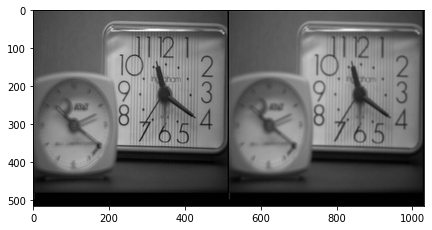

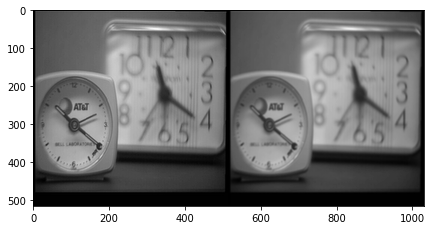

(1, 512, 512)


In [ ]:
#Test simplest deconvolution
import skimage.restoration as rst
us_noisy_pil = crop_image(get_image(fname_us, imsize)[0], d=32)
us_noisy_np = pil_to_np(us_noisy_pil)

mr_noisy_pil = crop_image(get_image(fname_mr, imsize)[0], d=32)
mr_noisy_np = pil_to_np(mr_noisy_pil)

psf = np.ones((5,5))/25

deconvolved_us = rst.richardson_lucy (us_noisy_np[0,:,:], psf, iterations=1)[None,:,:] #deconvolution
deconvolved_mr = rst.richardson_lucy (mr_noisy_np[0,:,:], psf, iterations=1)[None,:,:]

plot_image_grid([us_noisy_np,deconvolved_us], 4, 5)
plot_image_grid([mr_noisy_np,deconvolved_mr], 4, 5)

#original images
o_us_np = us_noisy_np 
o_mr_np = mr_noisy_np

us_noisy_np = deconvolved_us
us_noisy_pil = np_to_pil(deconvolved_us)
mr_noisy_np = deconvolved_mr
mr_noisy_pil = np_to_pil(deconvolved_mr)
print(us_noisy_np.shape)

In [4]:
#Estimate PSF and H
import skimage.restoration as rst
import scipy
us_noisy_pil = crop_image(get_image(fname_us, imsize)[0], d=32)
us_noisy_np = pil_to_np(us_noisy_pil)

mr_noisy_pil = crop_image(get_image(fname_mr, imsize)[0], d=32)
mr_noisy_np = pil_to_np(mr_noisy_pil)

psf_size = [5,5]

us_H, us_psf = estimatePSF(us_noisy_np[0], psf_size)
mr_H, mr_psf = estimatePSF(mr_noisy_np[0], psf_size)
us_psf = us_psf/np.sum(us_psf)
mr_psf = mr_psf/np.sum(mr_psf)
print(us_psf.dtype)

us_psf_np = us_psf[None,:] #numpy is [1,*,*] rather than [*,*]
mr_psf_np = mr_psf[None,:]
us_psf_torch = np_to_torch(us_psf_np).type(dtype).to(device = 'cuda')
mr_psf_torch = np_to_torch(mr_psf_np).type(dtype).to(device = 'cuda')

#torch convolution
# a = torch.nn.functional.conv2d(us_noisy_torch,us_psf_torch,padding = 2)


#cannot operation on GPU, but pytorch has convolution operation
# us_after_psf = scipy.ndimage.filters.correlate(us_noisy_np[0], us_psf, mode='mirror')[None,:,:] 
# us_after_psf = scipy.ndimage.filters.convolve(us_noisy_np[0], us_psf, mode='mirror')[None,:,:]
# plot_image_grid([us_noisy_np,us_after_psf], 4, 5) #should be blurer, cause this is operation on output rather than input


#Deconvolution richardson_lucy

# deconvolved_us = rst.richardson_lucy (us_noisy_np[0,:,:], us_psf, iterations=5)[None,:,:] #deconvolution
# deconvolved_mr = rst.richardson_lucy (mr_noisy_np[0,:,:], mr_psf, iterations=5)[None,:,:]

# plot_image_grid([us_noisy_np,deconvolved_us], 4, 5)
# plot_image_grid([mr_noisy_np,deconvolved_mr], 4, 5)

# #original images
# o_us_np = us_noisy_np 
# o_mr_np = mr_noisy_np

# us_noisy_np = deconvolved_us
# us_noisy_pil = np_to_pil(deconvolved_us)
# mr_noisy_np = deconvolved_mr
# mr_noisy_pil = np_to_pil(deconvolved_mr)


float64


# **Compute sensor gain**

[[1.         1.         0.9999685  ... 0.99973804 1.         1.        ]
 [1.         1.         0.9999685  ... 0.99973804 1.         1.        ]
 [1.         1.         0.999969   ... 0.99663154 0.99976483 0.99976483]
 ...
 [1.         1.         0.85065081 ... 0.70710678 0.70710678 0.70710678]
 [1.         1.         0.85065081 ... 0.70710678 0.70710678 0.70710678]
 [1.         1.         0.85065081 ... 0.70710678 0.70710678 0.70710678]]
[[0.         0.         0.00793676 ... 0.02288781 0.         0.        ]
 [0.         0.         0.00793676 ... 0.02288781 0.         0.        ]
 [0.         0.         0.00787377 ... 0.08200964 0.02168608 0.02168608]
 ...
 [0.         0.         0.52573111 ... 0.70710678 0.70710678 0.70710678]
 [0.         0.         0.52573111 ... 0.70710678 0.70710678 0.70710678]
 [0.         0.         0.52573111 ... 0.70710678 0.70710678 0.70710678]]


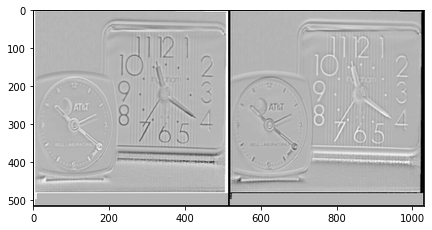

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 1.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 1.        , ..., 0.70710678,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 1.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 1.        , ..., 0.70710678,
         0.        , 0.        ],
        [0. 

In [5]:
# As we don't have ground truth
us_pil = us_noisy_pil
us_np = us_noisy_np

mr_pil = mr_noisy_pil
mr_np = mr_noisy_np

#compute sensor gain
# sensor_gain
us_sg, mr_sg = sensor_gain(us_np[0],mr_np[0],mbSize=1)
print(us_sg)
print(mr_sg)
us_sg_np = us_sg[None,:] #numpy is [1,*,*] rather than [*,*]
mr_sg_np = mr_sg[None,:]
us_sg_torch = np_to_torch(us_sg_np).type(dtype).to(device = 'cuda')
mr_sg_torch = np_to_torch(mr_sg_np).type(dtype).to(device = 'cuda')
plot_image_grid([us_sg_np,mr_sg_np], 4, 5)

In [ ]:
#Test
a = torch.randn(1,2,3)
b = torch.randn(1,2,3)
c = a * b #same as np.multiply()
print(a)
print(b)
print(c)
a = np.array([1,2,3,4]).reshape(2,2)
b = np.array([1,2,3,4]).reshape(2,2)
# print(np.dot(a,b))
# print(np.multiply(a,b))

c = np.append(a,b)
c = np.append(c,b)
c = np.array([0.3]*4)

b = np.ones(3)
a = np.random.rand(4,8)
m1 = np.dot(a,a.transpose())
m2 = np.zeros((4,4))

for i in range(a.shape[1]):
    temp_a = a[:,i][:,None]
    m2 += np.dot(temp_a, temp_a.transpose())  

tensor([[[ 1.5955,  0.4974,  0.1378],
         [-0.3494, -0.5141,  0.5600]]])
tensor([[[-2.0421e+00,  9.5970e-01, -8.7409e-01],
         [ 1.4020e-03,  1.1344e+00, -1.4215e+00]]])
tensor([[[-3.2581e+00,  4.7736e-01, -1.2047e-01],
         [-4.8987e-04, -5.8314e-01, -7.9605e-01]]])


# Setup For MR and US


In [6]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'
KERNEL_TYPE='lanczos2'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99


num_iter = 2000
input_depth = 1
figsize = 5 

NET_TYPE = 'skip' # UNet, ResNet

net = get_net(input_depth, 'skip', pad,
              n_channels=1,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

# net = skip(
#             input_depth, 1, 
#             num_channels_down = [8, 16, 32, 64, 128], 
#             num_channels_up   = [8, 16, 32, 64, 128],
#             num_channels_skip = [0, 0, 0, 4, 4], 
#             upsample_mode='bilinear',
#             need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)



#net input is white noise
net_input = get_noise(input_depth, INPUT, (us_pil.size[1], us_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

us_noisy_torch = np_to_torch(us_noisy_np).type(dtype)
mr_noisy_torch = np_to_torch(mr_noisy_np).type(dtype)

Number of params: 2181737


## Optimise for MR and US

Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_r

iteration =  0
tensor(93766.1250, device='cuda:0', grad_fn=<AddBackward0>)


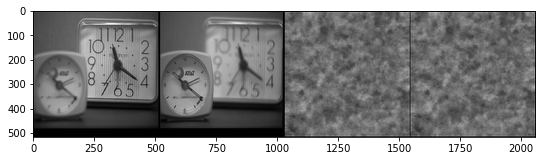

iteration =  100
tensor(12958.8584, device='cuda:0', grad_fn=<AddBackward0>)


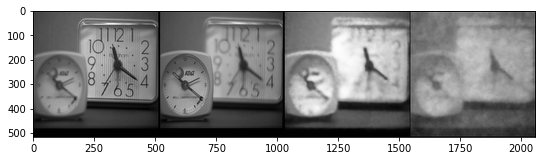

iteration =  200
tensor(8621.8809, device='cuda:0', grad_fn=<AddBackward0>)


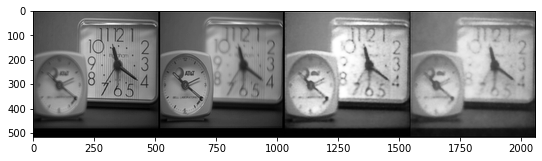

iteration =  300
tensor(7108.9976, device='cuda:0', grad_fn=<AddBackward0>)


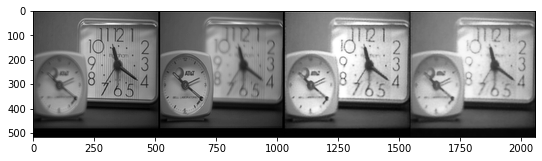

iteration =  400
tensor(6513.9136, device='cuda:0', grad_fn=<AddBackward0>)


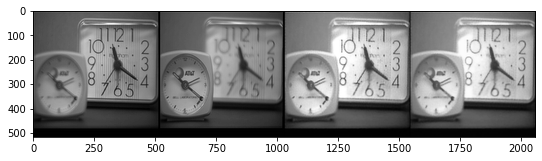

iteration =  500
tensor(5674.4546, device='cuda:0', grad_fn=<AddBackward0>)


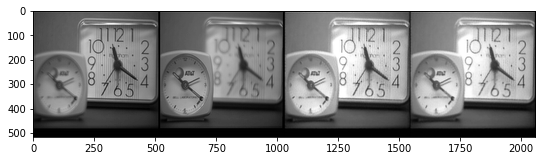

iteration =  600
tensor(5088.5742, device='cuda:0', grad_fn=<AddBackward0>)


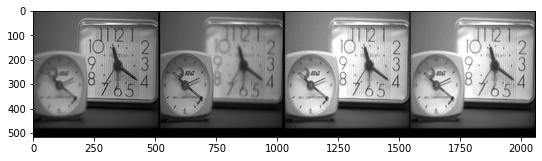

iteration =  700
tensor(4616.1812, device='cuda:0', grad_fn=<AddBackward0>)


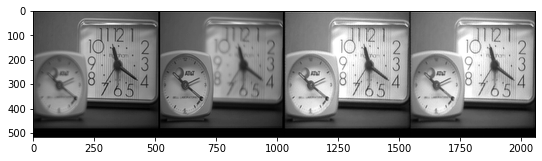

iteration =  800
tensor(4437.7251, device='cuda:0', grad_fn=<AddBackward0>)


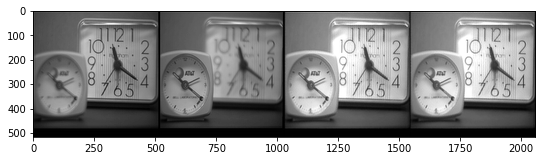

iteration =  900
tensor(4307.7314, device='cuda:0', grad_fn=<AddBackward0>)


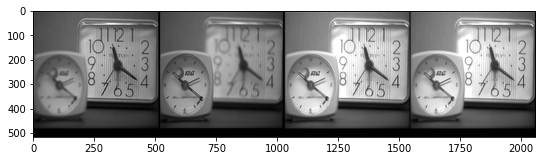

iteration =  1000
tensor(4317.3369, device='cuda:0', grad_fn=<AddBackward0>)


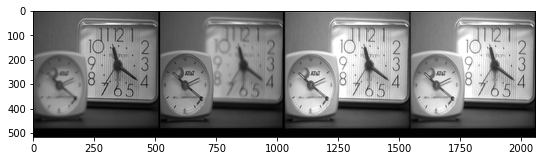

iteration =  1100
tensor(4190.4673, device='cuda:0', grad_fn=<AddBackward0>)


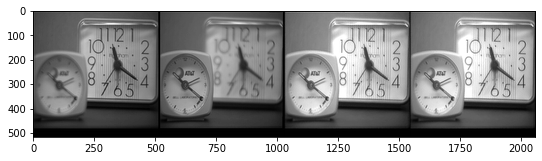

iteration =  1200
tensor(3961.0308, device='cuda:0', grad_fn=<AddBackward0>)


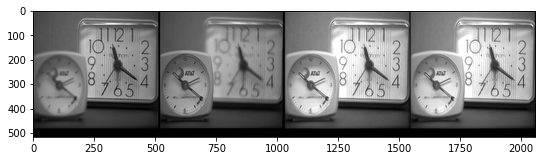

iteration =  1300
tensor(3970.7080, device='cuda:0', grad_fn=<AddBackward0>)


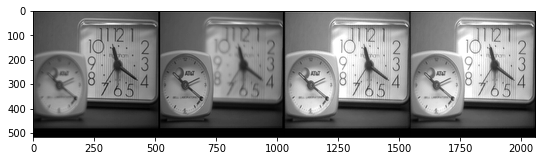

iteration =  1400
tensor(3798.3535, device='cuda:0', grad_fn=<AddBackward0>)


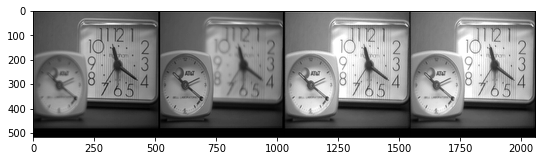

iteration =  1500
tensor(3745.2261, device='cuda:0', grad_fn=<AddBackward0>)


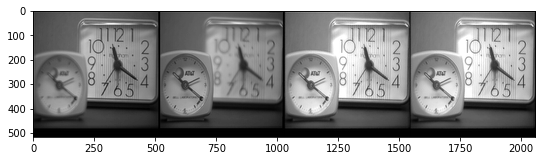

iteration =  1600
tensor(3710.8381, device='cuda:0', grad_fn=<AddBackward0>)


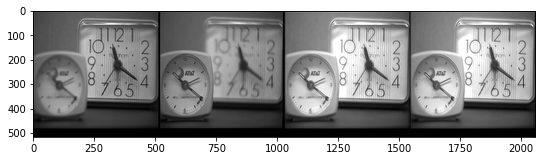

iteration =  1700
tensor(3677.5151, device='cuda:0', grad_fn=<AddBackward0>)


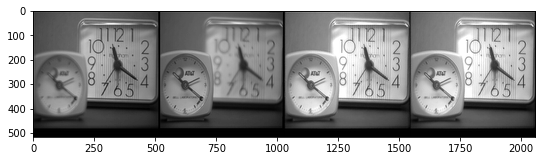

iteration =  1800
tensor(3643.9385, device='cuda:0', grad_fn=<AddBackward0>)


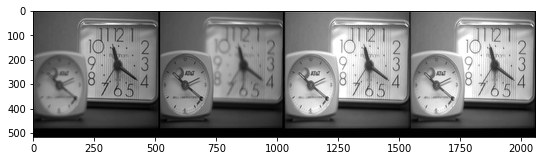

iteration =  1900
tensor(3732.8020, device='cuda:0', grad_fn=<AddBackward0>)


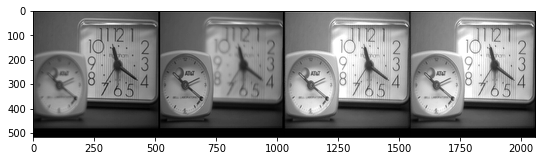

In [7]:
import skimage.restoration as rst

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0
us_para = 0.5
norm_lambda = 1e-6
best_loss = float('inf')
best_out = None
best_avg = None

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input, best_loss, best_out, best_avg

    #xudong avoid start from the previous running result
    # if reg_noise_std > 0:
    #     net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    # print(out.shape)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    # #simplest decovolution -- denosing should be operation on observed images rather than output
    # np_out = torch_to_np(out)[0,:,:]
    # deconvolved_out = rst.richardson_lucy (np_out, psf, iterations=20)[None,None,:,:] #denoising
    # deconvolved_out = torch.tensor(deconvolved_out, requires_grad=True).type(dtype).to(device = 'cuda')
    
    #weighting of US and MR  mean square error  
    # total_loss = us_para * mse(us_sg_torch * torch.nn.functional.conv2d(out,us_psf_torch,padding = 2), us_noisy_torch) + (1 - us_para) * mse(mr_sg_torch * torch.nn.functional.conv2d(out,mr_psf_torch,padding = 2), mr_noisy_torch) 
    total_loss = torch.norm((us_sg_torch * torch.nn.functional.conv2d(out,us_psf_torch,padding = 2) - us_noisy_torch),p=1) + torch.norm((mr_sg_torch * torch.nn.functional.conv2d(out,mr_psf_torch,padding = 2) - mr_noisy_torch),p=1) 
    # print('loss:',total_loss)
    #Adding norm
    # total_loss += norm_lambda * torch.norm(out, p = 2)
    # print('loss with norm:',total_loss)
    if total_loss < best_loss:
        best_loss = total_loss
        best_out = out
        best_avg = out_avg
    
    total_loss.backward()
        
    
    ####only us image
    psrn_noisy = compare_psnr(us_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(us_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(us_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    # print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        # plot_image_grid([us_np,mr_np,torch_to_np(out)], factor=figsize, nrow=4)
        # plot_image_grid([np.clip(us_np,0,1),np.clip(mr_np,0,1),np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=4)
        print("iteration = ",i)
        print(total_loss)
        plot_image_grid([np.clip(us_np,0,1),np.clip(mr_np,0,1),np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=4)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)


Best loss is:  tensor(3460.3901, device='cuda:0', grad_fn=<AddBackward0>)
Best result as shown below:


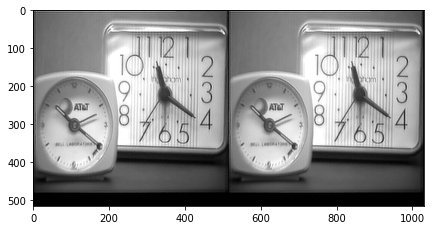

[[[0.2509804  0.2509804  0.24705882 ... 0.20784314 0.09019608 0.        ]
  [0.25490198 0.2509804  0.24705882 ... 0.21176471 0.09411765 0.        ]
  [0.25490198 0.25490198 0.2509804  ... 0.21568628 0.09411765 0.00392157]
  ...
  [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]]]
[[[0.5521663  0.49781412 0.3977959  ... 0.21890354 0.16254953 0.13976344]
  [0.49214613 0.44529378 0.3567968  ... 0.21173954 0.15542173 0.13302715]
  [0.34494323 0.32086965 0.27265835 ... 0.20575044 0.14882241 0.1253746 ]
  ...
  [0.00496124 0.00494333 0.00477012 ... 0.00504174 0.00507673 0.00510232]
  [0.00505383 0.00510508 0.00514635 ... 0.00481302 0.00510196 0.0053968 ]
  [0.00502066 0.00504169 0.00534143 ... 0.00482493 0.00526859 0.00538977]]]


In [8]:
print("Best loss is: ",best_loss)
print("Best result as shown below:")
plot_image_grid([torch_to_np(best_out),torch_to_np(best_avg)], factor=figsize, nrow=4)
#save best result
print(us_noisy_np)
print(torch_to_np(best_out))
np_to_pil(torch_to_np(best_out)).save('data/denoising/sr_sym9_L1loss_noNorm_clock.jpg')
np_to_pil(torch_to_np(best_avg)).save('data/denoising/sravg_sym9_L1loss_noNorm_clock.jpg')

In [ ]:
import inspect
# print(inspect.getsource(crop_image))
print(inspect.getsourcefile(crop_image))
print(inspect.getsource(np_to_pil))

/content/utils/common_utils.py
def np_to_pil(img_np): 
    '''Converts image in np.array format to PIL image.
    
    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)
#     ar = img_np.astype(np.uint16)
    
    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)



In [ ]:
out_np = torch_to_np(net(net_input))
# q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
#Test
a = abs(np.random.randn(2,2))
print(a)
b = np.square(a)
c = np.sqrt(b)
print(b)
print(c)


[[2.11873373 1.17488028]
 [0.60581496 0.73377557]]
[[4.48903262 1.38034368]
 [0.36701177 0.53842659]]
[[2.11873373 1.17488028]
 [0.60581496 0.73377557]]


In [ ]:
import matlab.engine
import numpy as np
from utils.common_utils import *
size = 6

a = np.ones(size**2).reshape(size,size)
b = np.ones(size**2).reshape(size,size)
[sg1, sg2] = sensor_gain(a,b,2)

mat_a = matlab.double(a.tolist())
mat_b = matlab.double(b.tolist())

eng = matlab.engine.start_matlab()
beta = eng.SensorGain(mat_a,mat_b) #only return the first variable
print(sg1)
print(beta)


[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
[[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475]]


(1, 512, 512)
(1, 512, 512)


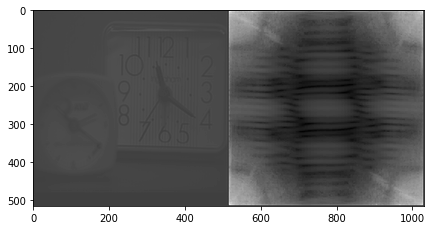

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.05057245e-02, ...,
         1.02547060e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 3.17448162e-04, ...,
         1.04729402e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

In [ ]:
import numpy as np
from skimage.restoration import (denoise_wavelet, estimate_sigma)
import matplotlib.pyplot as plt

print(us_noisy_np.shape)

# a = np.random.randn(2,3)
a = us_noisy_np
c = np.log(abs(np.fft.fft2(a[0])))
deltaC = c - medfilt2d(c)
lamb = 0.05*abs(deltaC)
r = np.sign(deltaC)*np.maximum(0,abs(deltaC)-lamb)
gr = c - r
# plt.plot(gr)

sigma_est = estimate_sigma(gr) 
im_visushrink = denoise_wavelet(gr, method = 'VisuShrink',mode = 'soft',wavelet_levels = 3,sigma = sigma_est,rescale_sigma=True)[None,:,:]
print(im_visushrink.shape)
plot_image_grid([a,im_visushrink], 4, 5)


In [ ]:

import torch.nn as nn
import torch
 
 
im = torch.randn(1, 1, 5, 5)
print(im.shape)
c = nn.Conv2d(1, 1, kernel_size=2, stride=2, padding=1)
output = c(im)
print(torch.norm(output,p=1))
 


torch.Size([1, 1, 5, 5])
tensor(2.9032, grad_fn=<NormBackward1>)
